This lab will teach how to use PyTorch by making a simple neural network model. Regradless of model's complexity, creating any model can be completed in a similar way. We will use the **Fashion MNIST** dataset, one of the variants of the MNIST dataset. It has the same property as a normal MNIST, with the same size (28*28) and the same number of classes (10), but the images represent fashion items rather than handwritten digits, which means it might have more complexity than normal MNIST.

Because of its complexity in each class, the problem is significantly more challenging than normal MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST. Below is an example of Fashion MNIST.


![alt text](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

### Section 1: Import PyTorch and load a sample dataset


In [1]:
%%capture
!pip install numpy torch

In [1]:
import torch as pt

In [2]:
import numpy as np

In [3]:
# version?
pt.__version__

'2.6.0+cu126'

In [4]:
!git clone https://github.com/zalandoresearch/fashion-mnist data

Cloning into 'data'...


In [3]:
import os
os.listdir('data/data/fashion')

['t10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 'unzipped']

Let's load the data:

In [4]:
# import mnist_reader:
import data.utils.mnist_reader as mnist_reader

In [5]:
# load data:
X_train_full, y_train_full = mnist_reader.load_mnist('data/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

In [6]:
# type?
type(X_train_full)

numpy.ndarray

In [10]:
# shape?
X_train_full.shape, X_test.shape

((60000, 784), (10000, 784))

In [11]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

As the dataset is composed of grayscale pixels, the datatype of it is unsigned integer. The dataset also has a pixed range [0, 255] so it does not need to take higher bit than 8.

In [48]:
# dtype?
X_train_full.dtype

dtype('float64')

Besides that, PyTorch models are also usually evaluated by one more separate set called validation set as training is an iterative and time-consuming process and we do not know when we need to stop clearly. So we would like to estimate the right time to interrupt the training process by checking its performance for each iteration.

To create a validation set, there can be many options, we can explicitly split the dataset using index, or we can just use a training set but with the option stating we want to validate, when we actually fit the model. However, this time we will use scikit-learn's `train_test_split` method to create a validation set as it can provide a nice stratification option.

We need a simiple normalization - as we all know the graysclae ranges from 0 to 255...

In [7]:
# Introduced in the coursebook
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [8]:
X_test = X_test / 255.

In [15]:
from sklearn.model_selection import train_test_split

# normalize:
X_train_full = X_train_full / 255.

# split data:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, 
                                                      y_train_full, 
                                                      test_size=0.5, 
                                                      stratify=y_train_full, 
                                                      random_state=42,
                                                      shuffle=True)
#continue

In [ ]:
# shape?
#continue

Here we prepared the class names of the fashion MNIST dataset for your convenience.

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [17]:
# Use the numeric label to get the class name, e.g:
class_names[0]

'T-shirt/top'

We can also try to see each data instance by using **plt.imshow**.

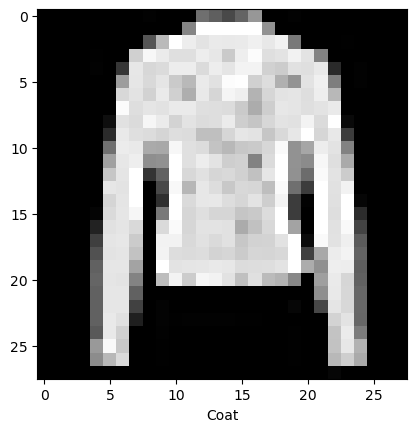

In [18]:
import matplotlib.pyplot as plt
i = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[i].reshape((28, 28)), cmap='gray') # cmap to make it recognize grayscale
plt.xlabel(class_names[y_train[i]])
plt.show()

#### Optimizing memory consuption using pipelines:

Imagine taking the above approach with very large datasets (e.g. used for training modern LLMs). Loading all the data before training would exceed RAM and VRAM of almost any computer.

Therefore, we are going to use the [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) API:

---
***An abstract class representing a Dataset.***

*All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite* `__getitem__()`*, supporting fetching a data sample for a given key. Subclasses could also optionally overwrite* `__len__()`*, which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader. Subclasses could also optionally implement* `__getitems__()`*, for speedup batched samples loading. This method accepts list of indices of samples of batch and returns list of samples.*

---

In [51]:
from numpy.typing import NDArray
from typing import Tuple
from torch.utils.data import Dataset

class FashionMNIST(Dataset):
  def __init__(self, X:NDArray[np.int8], y:NDArray[np.int8]) -> None:
    # normalize:
    self.X = X.astype(np.float32) / 255.0
    self.y = y

  def __len__(self) -> int:
    return len(self.y)

  def __getitem__(self, idx:int) -> int:
    return self.X[idx], self.y[idx]

  @staticmethod
  def create_split(fraction_train:float, fraction_validation:float, fraction_test:float) -> Tuple[Dataset, Dataset, Dataset]:
    assert fraction_train + fraction_validation + fraction_test == 1.0

    # load data:
    train = mnist_reader.load_mnist('data/data/fashion', kind='train')
    t10k  = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

    data   = np.concatenate((train[0], t10k[0]), axis=0)
    labels = np.concatenate((train[1], t10k[1]), axis=0)

    # split data:
    n = len(labels)
    n_train = int(n * fraction_train)
    n_validation = int(n * fraction_validation)

    data_train = FashionMNIST(
        data[:n_train],
        labels[:n_train]
    )
    data_valid = FashionMNIST(
        data[n_train:n_train+n_validation],
        labels[n_train:n_train+n_validation]
    )
    data_test = FashionMNIST(
        data[n_train+n_validation:],
        labels[n_train+n_validation:]
    )

    return data_train, data_valid, data_test

It works like a list of tuples `(X, y)` in Python:

In [52]:
data, _, _ = FashionMNIST.create_split(.7, .1, .2)

In [53]:
# call to __len__:
len(data)

49000

In [54]:
# call to __getitem__:
data[5]

(array([0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.        , 0.        , 0.        , 0.08627451,
        0.34509805, 0.7372549 , 0.6745098 , 0.5176471 , 0.49019608,
        0.5529412 , 0.78039217, 0.56078434, 0.03529412, 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00392157, 0.        , 0.        , 0.07843138,
        0.5137255 , 0.78039217, 0.80784315, 0.76862746, 0.7921569 ,
        0.9490196 , 1.        , 1.        , 0.98039216, 0.87058824,
        0.77254903, 0.80784315, 0.7372549 , 0.49411765, 0.06666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.13725491, 0.8392157 , 0.7490196 , 0.7176471 ,
        0.69803923, 0.6862745 , 0.65882355, 0.5882353 , 0.63529414,
        0.62352943, 0.59607846, 0.61960787, 0.70

But the above implementation still loads everything at the time of instantiation of the `FashionMNIST` class. So let's transform the data into a format that you see more often with big datasets:

In [23]:
# unzip data:
target_dir = 'data/data/fashion/unzipped'
os.makedirs(target_dir, exist_ok=True)

train = mnist_reader.load_mnist('data/data/fashion', kind='train')
t10k  = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

data = np.concatenate((train[0], t10k[0]), axis=0)
labels = np.concatenate((train[1], t10k[1]), axis=0)

for i, x in enumerate(data):
  file = os.path.join(target_dir, f'img_{i:d}.npy')
  with open(file, 'wb') as f:
    np.save(f, x.reshape((28, 28)))

with open(os.path.join(target_dir, 'labels.npy'), 'wb') as f:
  np.save(f, labels)

In [24]:
os.listdir(target_dir)[:10]

['img_0.npy',
 'img_1.npy',
 'img_10.npy',
 'img_100.npy',
 'img_1000.npy',
 'img_10000.npy',
 'img_10001.npy',
 'img_10002.npy',
 'img_10003.npy',
 'img_10004.npy']

In [ ]:
class FashionMNIST(Dataset):
  def __init__(self, indices:NDArray[np.int32], labels:NDArray[np.int8]) -> None:
    self.indices = indices
    self.labels  = labels

  def __len__(self) -> int:
    return len(self.indices)

  def __getitem__(self, idx:int) -> int:
    # complete
    img_index = self.indices[idx]
    label = self.labels[idx]

    img_path = os.path.join(target_dir, f'img_{img_index}.npy')
    image = np.load(img_path).astype(np.float32) / 255.0
  
    return image, label
    

  @staticmethod
  def create_split(fraction_train:float, fraction_validation:float, fraction_test:float, stratify:bool=True, shuffle:bool=True) -> Tuple[Dataset, Dataset, Dataset]:
    assert fraction_train + fraction_validation + fraction_test == 1.0
    # complete
    labels_path = os.path.join(target_dir, 'labels.npy')
    labels = np.load(labels_path)

    indices = np.arange(len(labels))

    X_train, X_rest, y_train, y_rest = train_test_split(indices, labels, test_size=(fraction_validation + fraction_test), 
                                                      stratify=labels if stratify else None, shuffle=shuffle, random_state=42)
    
    test_ratio = fraction_test / (fraction_validation + fraction_test)

    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=test_ratio, 
                                                    stratify=y_rest if stratify else None, shuffle=shuffle, 
                                                    random_state=42)
    
    data_train = FashionMNIST(X_train, y_train)
    data_valid = FashionMNIST(X_val, y_val)
    data_test = FashionMNIST(X_test, y_test)

    return data_train, data_valid, data_test

In [25]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

In [26]:
data_train, data_valid, data_test = FashionMNIST.create_split(.7, .1, .2)

In [27]:
loader_train = DataLoader(data_train,             # dataset from which to load the data.
                          batch_size=BATCH_SIZE,  # how many samples per batch to load (default: 1).
                          shuffle=True,           # set to True to have the data reshuffled at every epoch (default: False).
                          sampler=None,           # defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented.
                                                  # If specified, shuffle must not be specified.
                          batch_sampler=None,     # like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.
                          drop_last=False)        # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
                                                  # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

In [28]:
# validation set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_valid = DataLoader(data_valid,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

In [29]:
# test set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_test  = DataLoader(data_test,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

#### Instantiating the network:

In [70]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(in_features=784, out_features=100, bias=True)
        self.layer2 = nn.Linear(in_features=100, out_features=len(class_names), bias=True)

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        x = F.relu(self.layer1(x))
        return F.softmax(self.layer2(x), dim=-1)

We can visualize the model using **keras.utils.plot_model**. It helps to figue out (or validate) the structure of complete models having multiple paths.

In [71]:
from torchsummary import summary

model = CustomNetwork()
summary(model, input_size=(784,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:

list(model.children())

[Linear(in_features=784, out_features=100, bias=True),
 Linear(in_features=100, out_features=10, bias=True)]

In [35]:
list(model.named_children())

[('layer1', Linear(in_features=784, out_features=100, bias=True)),
 ('layer2', Linear(in_features=100, out_features=10, bias=True))]

In [36]:
model.get_submodule('layer1')

Linear(in_features=784, out_features=100, bias=True)

In [37]:
# All modules in the model (including itself):
list(model.named_modules())

[('',
  CustomNetwork(
    (layer1): Linear(in_features=784, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=10, bias=True)
  )),
 ('layer1', Linear(in_features=784, out_features=100, bias=True)),
 ('layer2', Linear(in_features=100, out_features=10, bias=True))]

In [38]:
# You can get a generator object of parameters (weights) for each submodule using `parameters()`:
# !!! in order of instantiation !!!
list(model.parameters())[:2]

[Parameter containing:
 tensor([[-0.0249,  0.0115, -0.0336,  ..., -0.0316,  0.0024, -0.0138],
         [-0.0080,  0.0213, -0.0335,  ...,  0.0160, -0.0074, -0.0198],
         [ 0.0006, -0.0133, -0.0321,  ...,  0.0231,  0.0275, -0.0033],
         ...,
         [ 0.0324, -0.0257,  0.0038,  ..., -0.0167, -0.0236,  0.0010],
         [-0.0117,  0.0234,  0.0146,  ...,  0.0270, -0.0102,  0.0175],
         [-0.0156, -0.0310,  0.0162,  ...,  0.0060,  0.0189, -0.0068]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0334, -0.0314, -0.0133, -0.0188,  0.0177, -0.0290,  0.0282, -0.0098,
          0.0121, -0.0093,  0.0118, -0.0116,  0.0290,  0.0231,  0.0289,  0.0317,
          0.0279, -0.0116,  0.0153, -0.0269,  0.0282,  0.0286, -0.0289, -0.0263,
          0.0135, -0.0023, -0.0322,  0.0160,  0.0265, -0.0284, -0.0334,  0.0350,
         -0.0176,  0.0178, -0.0025, -0.0074, -0.0172, -0.0207,  0.0025, -0.0343,
         -0.0214, -0.0284, -0.0059,  0.0215, -0.0260, -0.0158, -0.0213,  0.0251

In [39]:
list(model.named_parameters())[:2]

[('layer1.weight',
  Parameter containing:
  tensor([[-0.0249,  0.0115, -0.0336,  ..., -0.0316,  0.0024, -0.0138],
          [-0.0080,  0.0213, -0.0335,  ...,  0.0160, -0.0074, -0.0198],
          [ 0.0006, -0.0133, -0.0321,  ...,  0.0231,  0.0275, -0.0033],
          ...,
          [ 0.0324, -0.0257,  0.0038,  ..., -0.0167, -0.0236,  0.0010],
          [-0.0117,  0.0234,  0.0146,  ...,  0.0270, -0.0102,  0.0175],
          [-0.0156, -0.0310,  0.0162,  ...,  0.0060,  0.0189, -0.0068]],
         requires_grad=True)),
 ('layer1.bias',
  Parameter containing:
  tensor([-0.0334, -0.0314, -0.0133, -0.0188,  0.0177, -0.0290,  0.0282, -0.0098,
           0.0121, -0.0093,  0.0118, -0.0116,  0.0290,  0.0231,  0.0289,  0.0317,
           0.0279, -0.0116,  0.0153, -0.0269,  0.0282,  0.0286, -0.0289, -0.0263,
           0.0135, -0.0023, -0.0322,  0.0160,  0.0265, -0.0284, -0.0334,  0.0350,
          -0.0176,  0.0178, -0.0025, -0.0074, -0.0172, -0.0207,  0.0025, -0.0343,
          -0.0214, -0.0284,

In [41]:
model.get_parameter('layer1.weight')

Parameter containing:
tensor([[-0.0249,  0.0115, -0.0336,  ..., -0.0316,  0.0024, -0.0138],
        [-0.0080,  0.0213, -0.0335,  ...,  0.0160, -0.0074, -0.0198],
        [ 0.0006, -0.0133, -0.0321,  ...,  0.0231,  0.0275, -0.0033],
        ...,
        [ 0.0324, -0.0257,  0.0038,  ..., -0.0167, -0.0236,  0.0010],
        [-0.0117,  0.0234,  0.0146,  ...,  0.0270, -0.0102,  0.0175],
        [-0.0156, -0.0310,  0.0162,  ...,  0.0060,  0.0189, -0.0068]],
       requires_grad=True)

In [62]:
class CustomNetwork(nn.Module):
    def __init__(self, dropout:float=.2) -> None:
        super().__init__()
        #continue
        self.layer1 = nn.Linear(in_features=784, out_features=300, bias=True)
        self.dropout = nn.Dropout(p=dropout)
        self.layer2 = nn.Linear(in_features=300, out_features=200, bias=True)
        self.layer3 = nn.Linear(in_features=200, out_features=10, bias=True)
     

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        #continue
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
    
        return F.softmax(self.layer3(x), dim = -1)

In [63]:
from torch.nn import Sequential
from collections import OrderedDict

Unnamed layers:

In [64]:
model = Sequential(
    nn.Linear(in_features=784, out_features=100, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=len(class_names), bias=True),
    nn.Softmax(dim=-1)
)

Named layers:

In [65]:
model = Sequential(OrderedDict([
    ('layer1',      nn.Linear(in_features=784, out_features=100, bias=True)),
    ('activation1', nn.ReLU()),
    ('layer1',      nn.Linear(in_features=100, out_features=len(class_names), bias=True)),
    ('activation2', nn.Softmax(dim=-1))
]))

In [72]:
# get gpu if available else cpu:
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
device

device(type='cuda')

In [73]:
# move a model or tensor to the device:
model = model.to(device)

Prediction on new instances:

In [74]:
X_new = pt.tensor(X_test[:3], dtype=pt.float32, device=device)
y_proba = model(X_new) # this returns a probability?
y_proba = y_proba.detach().cpu().numpy() # to numpy
y_proba

array([[0.10255852, 0.10388899, 0.09145649, 0.09475741, 0.10836214,
        0.10566334, 0.10971875, 0.09354396, 0.09645783, 0.09359254],
       [0.10259294, 0.10387671, 0.0913638 , 0.0947845 , 0.10835306,
        0.10566873, 0.10972735, 0.09358283, 0.09645569, 0.09359434],
       [0.10256168, 0.10389658, 0.09143367, 0.09479298, 0.10837191,
        0.10563503, 0.10975846, 0.0934996 , 0.09643364, 0.0936165 ]],
      dtype=float32)

In [75]:
np.array(class_names)[np.argmax(y_proba, axis=1)] #if we want to know the class names

array(['Shirt', 'Shirt', 'Shirt'], dtype='<U11')

In [2]:
import pandas as pd
from sklearn.metrics import f1_score
from typing import Optional, Callable

In [77]:
def epoch(model:CustomNetwork, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
  # 1. set model to train:
  model.train()

  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      # move tensors to correct device:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      # reset all gradients to zero:
      optimizer.zero_grad()

      # create predictions:
      y_pred = model(X_batch)

      # calculate loss:
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

      # backpropagate loss:
      loss.backward()

      # update weights:
      optimizer.step()

  return np.mean(losses)

In [78]:
def evaluate(model:CustomNetwork, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None):
  # 1. set model to eval:
  model.eval()

  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    # move tensors to correct device:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    labels.extend(y_batch.cpu().detach().numpy())

    # create predictions:
    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())

    # calculate loss:
    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

  # calculate f1 score:
  f1 = f1_score(
    y_batch.cpu().detach().numpy(),
    y_pred.argmax(dim=1).cpu().detach().numpy(),
    average='macro'
  )

  if loss_fn is None: return {'f1':f1}
  else: return {'loss':np.mean(losses), 'f1':f1}

In [79]:
def fit(model:CustomNetwork, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float):
  # instantiate optimizer:
  optimizer = pt.optim.SGD(model.parameters(), lr=lr)

  # instantiate loss function:
  loss_fn = pt.nn.CrossEntropyLoss()

  history = []
  for i in range(epochs):
    # train for one epoch:
    loss_train = epoch(model, loader_train, optimizer, loss_fn)

    # evaluate on validation:
    metrics = evaluate(model, loader_valid, loss_fn)

    # save metrics:
    history.append({
      'loss_train':loss_train,
      'loss_valid': metrics['loss'],
      'f1_valid': metrics['f1']
    })

    # print message:
    print(f'Epoch {i+1:d}/{epochs:d}:', *[f'{metric} = {history[-1][metric]:.2f};' for metric in history[-1]], sep='\t')

  # return history:
  return pd.DataFrame(history)

Fit the model for 30 epochs:

Epoch 1/30:	loss_train = 2.20;	loss_valid = 2.06;	f1_valid = 0.31;
Epoch 2/30:	loss_train = 1.95;	loss_valid = 1.88;	f1_valid = 0.53;
Epoch 3/30:	loss_train = 1.86;	loss_valid = 1.85;	f1_valid = 0.53;
Epoch 4/30:	loss_train = 1.83;	loss_valid = 1.82;	f1_valid = 0.53;
Epoch 5/30:	loss_train = 1.81;	loss_valid = 1.80;	f1_valid = 0.64;
Epoch 6/30:	loss_train = 1.79;	loss_valid = 1.78;	f1_valid = 0.64;
Epoch 7/30:	loss_train = 1.77;	loss_valid = 1.77;	f1_valid = 0.64;
Epoch 8/30:	loss_train = 1.76;	loss_valid = 1.76;	f1_valid = 0.64;
Epoch 9/30:	loss_train = 1.76;	loss_valid = 1.76;	f1_valid = 0.64;
Epoch 10/30:	loss_train = 1.75;	loss_valid = 1.75;	f1_valid = 0.64;
Epoch 11/30:	loss_train = 1.75;	loss_valid = 1.75;	f1_valid = 0.64;
Epoch 12/30:	loss_train = 1.74;	loss_valid = 1.75;	f1_valid = 0.64;
Epoch 13/30:	loss_train = 1.74;	loss_valid = 1.74;	f1_valid = 0.67;
Epoch 14/30:	loss_train = 1.73;	loss_valid = 1.73;	f1_valid = 0.67;
Epoch 15/30:	loss_train = 1.72;	loss_valid = 1.73;	f1_val

<Axes: xlabel='epoch', ylabel='loss'>

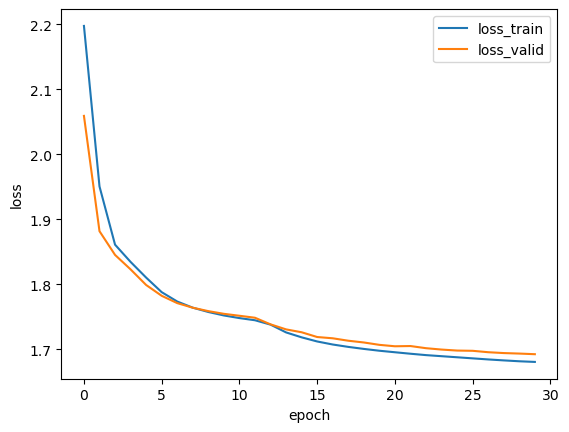

In [80]:
# instantiate model and move to device:
model = CustomNetwork().to(device)

# train model:
history = fit(model, loader_train, loader_valid, epochs=30, lr=.01)

# plot history:
history[['loss_train', 'loss_valid']].plot(xlabel='epoch', ylabel='loss')

In [81]:
evaluate(model, loader_test) #evaluate on the test set

{'f1': 0.873015873015873}

In [ ]:
def epoch(model:CustomNetwork, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
  #pass
  model.train()
  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()

      y_pred = model(X_batch)

      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())
      loss.backward()
      optimizer.step()

  return np.mean(losses)


def evaluate(model:CustomNetwork, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None):
  #pass
  model.eval()
  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    labels.extend(y_batch.cpu().detach().numpy())

    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())

    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

  f1 = f1_score(
    y_batch.cpu().detach().numpy(),
    y_pred.argmax(dim=1).cpu().detach().numpy(),
    average='macro'
  )

  if loss_fn is None: 
    return {'f1': f1}
  else:
    return {'loss': np.mean(losses), 'f1': f1}
  

def fit(model:CustomNetwork, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float, patience:int):
  #pass
  optimizer = pt.optim.Adam(model.parameters(), lr=lr)
  loss_fn = pt.nn.CrossEntropyLoss()
  scheduler = pt.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.33,
    total_iters=10
  )

  best_loss = float('inf')
  best_model_state = model.state_dict()
  patience_count = 0
  history = []

  for i in range(epochs):
    loss_train = epoch(model, loader_train, optimizer, loss_fn)
    metrics = evaluate(model, loader_valid, loss_fn)

    history.append({
      'loss_train': loss_train,
      'loss_valid': metrics['loss'],
      'f1_valid': metrics['f1']
    })

    if metrics['loss'] < best_loss:
      best_loss = metrics['loss']
      best_model_state = model.state_dict()
      patience_count = 0
    else:
      patience_count += 1
      
    if patience_count >= patience:
      model.load_state_dict(best_model_state)
      break
    
    scheduler.step()

  return pd.DataFrame(history)

In [82]:
pt.save(model, 'model.pt')

In [50]:
# this saves a zipfile!
!unzip model.pt

Archive:  model.pt
 extracting: model/data.pkl          
 extracting: model/byteorder         
 extracting: model/data/0            
 extracting: model/data/1            
 extracting: model/data/2            
 extracting: model/data/3            
 extracting: model/version           
 extracting: model/.data/serialization_id  


In [83]:
model = pt.load('model.pt', weights_only=False) # "weights_only = True" only loads PyTorch Tensors in the model file!
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


**Option 2:** save/load state_dict

In [52]:
import pickle

In [53]:
with open('model_state_dict.pkl', 'wb') as f:
  pickle.dump(model.state_dict(), f)

In [54]:
with open('model_state_dict.pkl', 'rb') as f:
  state_dict = pickle.load(f)
model.load_state_dict(state_dict)
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


1. Get training and test data:

In [9]:
# 1.1 download https://www.google.com/url?q=https%3A%2F%2Fnextilearn.dsv.su.se%2Fmod%2Fresource%2Fview.php%3Fid%3D25386 to data.zip

# 1.2 unzip data.zip
#!unzip data.zip

# 1.3 check files:
os.listdir('data/task5')

['data_test.csv', 'data_train.csv', 'description.md', 'labels_train.csv']

2. Create Data Pipeline:

In [2]:
# 2.1 load training data:
data_train = pd.read_csv('data/task5/data_train.csv', index_col=0)
labels_train = pd.read_csv('data/task5/labels_train.csv', index_col=0)

# 2.2 load test data (no labels):
data_test = pd.read_csv('data/task5/data_test.csv', index_col=0)

#...

3. Create Model:

In [ ]:
#...
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

class feature_eng(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_featured = X.copy()

        lat_rad = np.radians(X['Latitude'])
        lon_rad = np.radians(X['Longitude'])
        
        X_featured['lat_lon_x'] = np.cos(lat_rad) * np.cos(lon_rad)
        X_featured['lat_lon_y'] = np.cos(lat_rad) * np.sin(lon_rad)
        X_featured['lat_lon_z'] = np.sin(lat_rad)

        X_featured = X_featured.drop(columns=['Latitude', 'Longitude'])

        return X_featured
    
preprocessor = Pipeline([
    ('feature_eng', feature_eng()),
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer())
])


class MLP_reg:
    def __init__(self, input_dim=None, hidden1=256, hidden2=128,
                 dropout=0.2, lr=0.001, batch_size=32, epochs=30, 
                 patience=5, start_factor=1.0, end_factor=0.33, total_iters=10, 
                 device='cuda' if torch.cuda.is_available() else 'cpu', scale_target=True, 
                 verbose=True, weight_decay=1e-5, clip_grad=True, max_norm=1.0):
        
        self.input_dim = input_dim
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        #self.hidden3 = hidden3

        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.device = device
        self.scale_target = scale_target
        self.y_scaler = StandardScaler() if scale_target else None
        self.history = None
        self.verbose = verbose
        self.weight_decay = weight_decay
        self.clip_grad = clip_grad
        self.max_norm = max_norm

    def _build_model(self):
        self.model = nn.Sequential(
            #hidden1
            nn.Linear(self.input_dim, self.hidden1, bias=True),
            nn.BatchNorm1d(self.hidden1),
            nn.ReLU(),
            nn.Dropout(self.dropout),

            #hidden2
            nn.Linear(self.hidden1, self.hidden2, bias=True),
            nn.BatchNorm1d(self.hidden2),
            nn.ReLU(),
            nn.Dropout(self.dropout),

            #hidden3
            #nn.Linear(self.hidden2, self.hidden3, bias=True),
            #nn.BatchNorm1d(self.hidden3),
            #nn.ReLU(),
            #nn.Dropout(self.dropout),
            
            #output
            nn.Linear(self.hidden2, 1, bias=True)

        )

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.LinearLR(
            self.optimizer,
            start_factor=self.start_factor,
            end_factor=self.end_factor,
            total_iters=self.total_iters
        )

    def fit(self, X, y, X_val=None, y_val=None):
        if self.input_dim is None:
            self.input_dim = X.shape[1]

        self._build_model()
        self.model.to(self.device)

        X = torch.tensor(X, dtype=torch.float32).to(self.device)

        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values
        y = y.reshape(-1, 1)

        if self.scale_target:
            y = self.y_scaler.fit_transform(y)
        y = torch.tensor(y, dtype=torch.float32).to(self.device)

        if X_val is not None and y_val is not None:
            X_val = torch.tensor(X_val, dtype=torch.float32).to(self.device)

            if isinstance(y_val, (pd.Series, pd.DataFrame)):
                y_val = y_val.values
            y_val = y_val.reshape(-1, 1)

            if self.scale_target:
                y_val = self.y_scaler.transform(y_val)
            y_val = torch.tensor(y_val, dtype=torch.float32).to(self.device)
        
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_loss= float('inf')
        early_stop_count = 0
        best_model_state = None
        history = []

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0
            for batch_X, batch_y in loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()

                if self.clip_grad:
                    nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.max_norm)

                self.optimizer.step()
                epoch_loss += loss.item()

            self.scheduler.step()
            train_loss = epoch_loss / len(loader)

            val_loss = None
            if X_val is not None and y_val is not None:
                val_loader = torch.utils.data.DataLoader(
                    torch.utils.data.TensorDataset(X_val, y_val), 
                    batch_size=self.batch_size, 
                    shuffle=False)
                
                val_loss = 0
                self.model.eval()
                with torch.no_grad():
                    for batch_X_val, batch_y_val in val_loader:
                        val_pred = self.model(batch_X_val)
                        loss_val = self.criterion(val_pred, batch_y_val)
                        val_loss += loss_val.item() * batch_X_val.size(0)

                val_loss /= len(X_val)

            history.append({
                'epoch': epoch+1,
                'train_loss': train_loss,
                'val_loss': val_loss
            })

            if self.verbose:
                if val_loss is not None:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                early_stop_count = 0
                best_model_state = self.model.state_dict()
            else:
                early_stop_count += 1

            if early_stop_count >= self.patience:
                self.model.load_state_dict(best_model_state)
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break
        
        df_history = pd.DataFrame(history)
        self.history = df_history
        return self

    def predict(self, X):
        self.model.eval()
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X).cpu().numpy().flatten()
        if self.scale_target:
            predictions = self.y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            
        return predictions


4. Train model on `data_train` and `labels_train`:

In [53]:
#...
df_train = preprocessor.fit_transform(data_train)
df_test = preprocessor.transform(data_test)

Kfold = KFold(n_splits=3, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mse_scores = []
histories = []
oof_pred = np.zeros(df_train.shape[0])
test_pred = torch.zeros(df_test.shape[0], dtype=torch.float32).to(device)


for fold_idx, (train_idx, val_idx) in enumerate(Kfold.split(df_train, labels_train)):
    print(f"Fold {fold_idx+1}/{Kfold.n_splits}")

    X_train_fold, X_val_fold = df_train[train_idx], df_train[val_idx]
    y_train_fold, y_val_fold = labels_train.iloc[train_idx], labels_train.iloc[val_idx]

    model = MLP_reg(input_dim=X_train_fold.shape[1], 
                    epochs=500, patience=10, batch_size=64, 
                    verbose=True, scale_target=True, 
                    dropout=0.5, lr=1e-4, 
                    device=device, 
                    hidden1=256, hidden2=256,
                    weight_decay=1e-5, clip_grad=True, max_norm=0.5)
    
    model.fit(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    # Evaluate on validation set
    y_pred_val = model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred_val)
    mse_scores.append(mse_score)
    
    oof_pred[val_idx] = y_pred_val
    test_pred += torch.tensor(model.predict(df_test), device = device) / Kfold.n_splits

    histories.append(model.history)
    
    print(f"Fold {fold_idx+1} MSE: {mse_score:.4f}")

print(f"Final Model MSE: {np.mean(mse_scores):.4f}")

Fold 1/3
Epoch 1/500, Train Loss: 0.8767, Validation Loss: 0.4578
Epoch 2/500, Train Loss: 0.6626, Validation Loss: 0.3931
Epoch 3/500, Train Loss: 0.6105, Validation Loss: 0.3968
Epoch 4/500, Train Loss: 0.5687, Validation Loss: 0.3719
Epoch 5/500, Train Loss: 0.5441, Validation Loss: 0.3635
Epoch 6/500, Train Loss: 0.5113, Validation Loss: 0.3796
Epoch 7/500, Train Loss: 0.4964, Validation Loss: 0.3767
Epoch 8/500, Train Loss: 0.4893, Validation Loss: 0.3695
Epoch 9/500, Train Loss: 0.4843, Validation Loss: 0.3605
Epoch 10/500, Train Loss: 0.4730, Validation Loss: 0.3634
Epoch 11/500, Train Loss: 0.4713, Validation Loss: 0.3530
Epoch 12/500, Train Loss: 0.4596, Validation Loss: 0.3555
Epoch 13/500, Train Loss: 0.4575, Validation Loss: 0.3566
Epoch 14/500, Train Loss: 0.4475, Validation Loss: 0.3515
Epoch 15/500, Train Loss: 0.4539, Validation Loss: 0.3502
Epoch 16/500, Train Loss: 0.4493, Validation Loss: 0.3514
Epoch 17/500, Train Loss: 0.4423, Validation Loss: 0.3447
Epoch 18/500, 

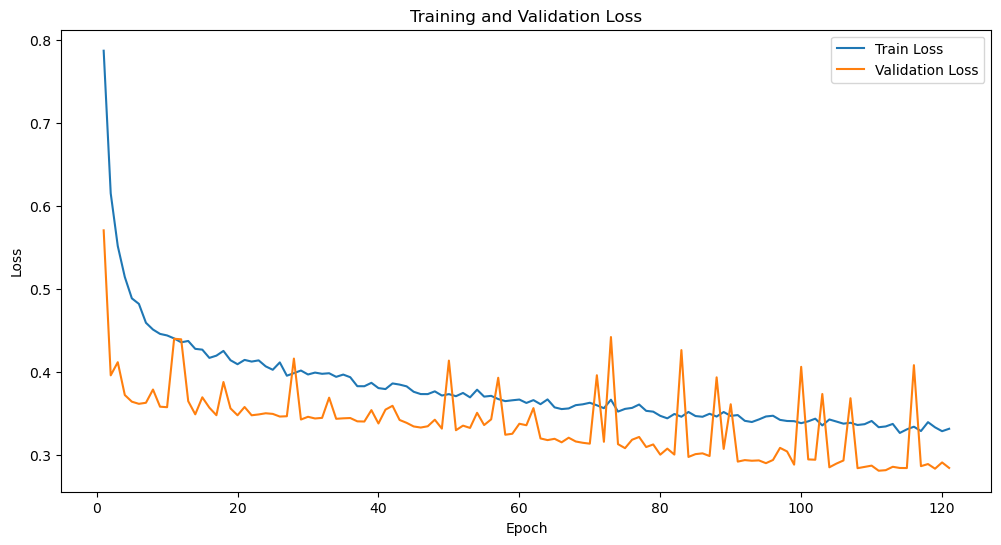

In [54]:
model.history
#plot history
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
plt.plot(model.history['epoch'], model.history['train_loss'], label='Train Loss')
plt.plot(model.history['epoch'], model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [56]:
#...
predictions = test_pred

pd.DataFrame(predictions.detach().cpu().numpy(), columns=['predictions']).to_csv('submission.csv')